In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM,BatchNormalization
from keras.layers import GlobalMaxPooling1D,Flatten
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [66]:
data = pd.read_csv("/home/shiva/Downloads/datasets/WK_1.csv",compression='gzip')
data.drop_duplicates('cleaned_data',inplace=True)

In [67]:
print(data.shape)
data.head()

(5373, 33)


,Unnamed: 0,cleaned_data,Administrative Law,Attorneys Fees,Banking Law,Bankruptcy Law,Civil Procedure,Civil Rights,Class Actions,Commercial Law,...,Immigration Law,Injury & Tort Law,Insurance Law,Intellectual Property,Labor & Employment Law,Property Law & Real Estate,Remedies,Sanctions,Securities Law,Sentencing
0,0,immaterial exception pendency motion suit dist...,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,1,consideration motion opinion case slip opinion...,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,3,terms time dismissal labor organization IAWCs ...,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,4,Plaintiffs limited ambulatory surgical center ...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,possession firearm jury trial jury court mistr...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


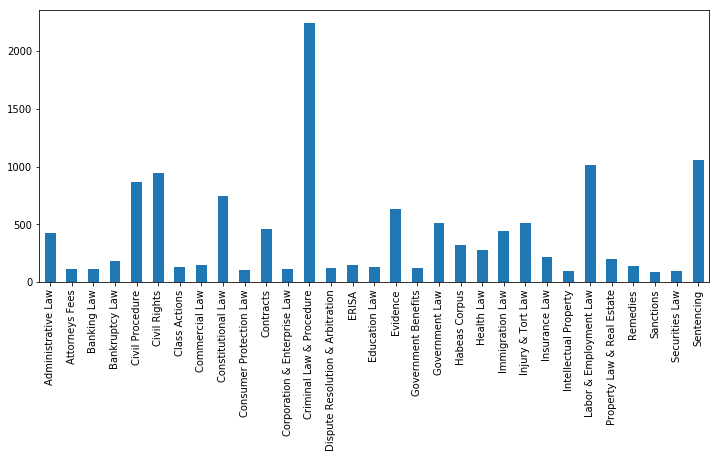

In [5]:
categories=data.columns
cat=[data[c].value_counts() for c in categories[2:]]
plt.figure(figsize=(12,5))
data.iloc[:,2:].sum(axis=0).plot.bar()

In [65]:
# taking  those samples having  greather than 50 words 

# df['word_len']=df.cleaned_data.apply(lambda x:len(simple_preprocess(x)))
# data=df.loc[df.word_len>=50]
# data.head(2)

# taking  those samples having  greather than 50 words 
# for i in range(len(data)):
#     print(data.iloc[i,2:-1].values,np.array(data.iloc[i,2:-1].values).sum())

In [7]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [8]:
# feature and label decleration 
X =data["cleaned_data"].apply(func=preprocess_text)

(5373, 31)

In [18]:
# selecting labels for model 1
labels=data[['Civil Procedure','Civil Rights','Evidence','Constitutional Law','Labor & Employment Law','Sentencing']]
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.20, random_state=420)
# First output
X_train.shape,np.array(y_train).shape

((4298,), (4298, 6))

# DeepLearning model  started from here 

In [11]:
# converting text into set of integer values of specific length 

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_ = tokenizer.texts_to_sequences(X_train)
X_test_ = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train_pad = pad_sequences(X_train_, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_, padding='post', maxlen=maxlen)
X_train.shape

(4298,)

In [12]:
# making embedding matrix fro weights in embedding layer using glove model
import pickle
from numpy import zeros
glove_file = pickle.load(open('glove_model.pkl','rb'))
embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    try:
        embedding_vector = glove_file.get_vector(word)
        embedding_matrix[index] = embedding_vector
    except:
        pass

In [13]:
# network of deeplearning model using LSTM and dense from keras 
model=Sequential()
model.add(Embedding(vocab_size,200, weights=[embedding_matrix], trainable=False))
model.add(LSTM(200))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         5555400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                12864     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 31)                2015      
Total params: 5,891,335
Trainable params: 335,807
Non-trainable params: 5,555,528
_________________________________________________________________
None


In [300]:
# fitting keras model 
history = model.fit(x=X_train_pad, y=y_train, batch_size=20, epochs=1, verbose=1, validation_split=0.2)

Train on 3438 samples, validate on 860 samples
Epoch 1/5
3438/3438 [==============================] - 90s 26ms/step - loss: 0.4876 - accuracy: 0.8177 - val_loss: 0.4741 - val_accuracy: 0.8302
Epoch 2/5
3438/3438 [==============================] - 58s 17ms/step - loss: 0.4875 - accuracy: 0.8177 - val_loss: 0.4743 - val_accuracy: 0.8302
Epoch 3/5
3438/3438 [==============================] - 36s 11ms/step - loss: 0.4875 - accuracy: 0.8177 - val_loss: 0.4742 - val_accuracy: 0.8302
Epoch 4/5
3438/3438 [==============================] - 36s 10ms/step - loss: 0.4874 - accuracy: 0.8177 - val_loss: 0.4745 - val_accuracy: 0.8302
Epoch 5/5
3438/3438 [==============================] - 36s 10ms/step - loss: 0.4874 - accuracy: 0.8177 - val_loss: 0.4741 - val_accuracy: 0.8302


In [302]:
# Evaluating keras model 
score = model.evaluate(x=X_test_pad, y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1075/1075 [==============================] - 4s 3ms/step
Test Score: 0.489078512358111
Test Accuracy: 0.8162790536880493


In [314]:
history.history

{'accuracy': [0.81769925, 0.81769925, 0.81769925, 0.81769925, 0.81769925],
 'loss': [0.4876466735529997,
  0.48751060797281914,
  0.4875231832872649,
  0.48740658323524855,
  0.48744205356407055],
 'val_accuracy': [0.830232560634613,
  0.830232560634613,
  0.830232560634613,
  0.830232560634613,
  0.830232560634613],
 'val_loss': [0.4741252064704895,
  0.4742542907249096,
  0.4742459744908089,
  0.47445988932321237,
  0.47411364524863486]}

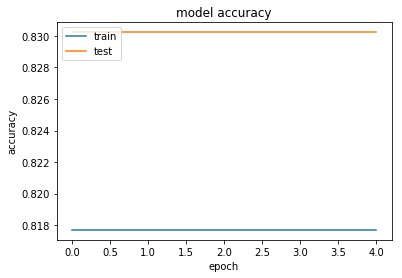

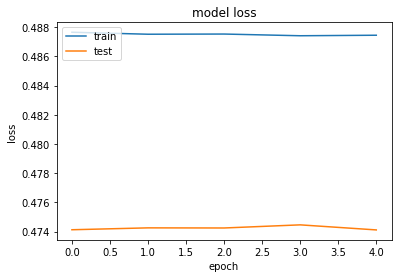

In [315]:
# visualization of traing accuracy and testing accuracy over each epochs 
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [308]:
# making 0/1 label of each value predicted by model based on threshhold value 
def sigmoid(scores):
    scores = np.negative(scores)
    exp = np.exp(scores)
    scores = 1 / (1 + exp)
    scores=[1 if i>0.5 else 0 for i in scores.ravel()]
    return scores
result=sigmoid(pred[1])

In [309]:
result

[1, 1, 1, 1]

In [317]:
history.validation_data

[array([[1029,   32,  334, ...,  439,  562,   53],
        [ 587, 1226,  857, ...,  192,  261, 1185],
        [ 277,   80,   38, ...,  370,   27,   10],
        ...,
        [   2,    1,   21, ...,   10,    2,    1],
        [  60,  902,  466, ...,  212, 1415, 1400],
        [3990,  104, 1322, ...,    2,    1,   13]], dtype=int32),
 array([[1, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 1, 1, 0],
        ...,
        [0, 0, 0, 1],
        [1, 1, 1, 0],
        [0, 0, 0, 0]]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

# Multilabel classification using ML model BinaryRelevence 

In [20]:
# using binary relevance
from sklearn.pipeline import make_pipeline 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from skmultilearn.problem_transform import BinaryRelevance,ClassifierChain,LabelPowerset
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [86]:
# making randomForest model with BinaryRelevence multillabel algorithm which makes available feature for every label 
classifier=BinaryRelevance(RandomForestClassifier(min_samples_leaf=1, min_samples_split=6, n_estimators=120, 
                             criterion='gini', bootstrap='False', n_jobs= -1))
pipe = make_pipeline(TfidfVectorizer(stop_words='english',ngram_range=(1,2),norm='l2',max_features=1200),classifier)
pipe.fit(X_train_,y_train_)
from imblearn.metrics import  classification_report_imbalanced 
y_pred = pipe.predict(X_test)
print("Random forest Accuracy:", accuracy_score(y_test.values, y_pred))
pred_df=pd.DataFrame(y_pred.toarray(),columns=list(y_test.head(0)))
[print(key,'\n',classification_report_imbalanced(y_test[key],pred_df[key])) for key in list(y_test.head(0))]

Random forest Accuracy: 0.6167441860465116
Civil Procedure 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.93      0.61      0.93      0.75      0.58       898
          1       0.62      0.61      0.93      0.62      0.75      0.55       177

avg / total       0.87      0.88      0.66      0.87      0.75      0.58      1075

Civil Rights 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.96      0.73      0.96      0.84      0.72       902
          1       0.79      0.73      0.96      0.76      0.84      0.68       173

avg / total       0.92      0.92      0.77      0.92      0.84      0.71      1075

Evidence 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.97      0.47      0.96      0.68      0.48       958
          1       0.69      0.47      0.97      0.56      0.68      0.43    

[None, None, None, None, None, None]

In [87]:
for f,s in zip(y_test.values,pred_df.values):
    print(f,s)

[0 0 0 0 0 0] [0 0 0 0 0 1]
[0 0 0 1 0 0] [0 1 0 1 1 0]
[0 0 0 0 0 0] [0 0 1 0 0 0]
[0 1 0 0 1 0] [0 1 0 0 1 0]
[0 0 0 0 0 1] [0 0 0 0 0 1]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 0 0 0 0 1] [0 0 0 0 0 1]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 1 0 0 1 0] [0 1 0 0 1 0]
[0 0 0 1 1 0] [0 1 0 0 1 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 0 1 0 0 0] [0 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 1]
[0 0 0 1 0 1] [0 0 0 1 0 0]
[1 0 0 0 0 0] [0 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[1 0 0 0 0 0] [0 0 0 0 0 0]
[1 0 0 0 0 0] [1 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 1 0 0 0]
[1 0 0 0 0 0] [1 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 1]
[0 0 0 1 0 0] [0 0 0 1 0 0]
[1 0 0 0 0 0] [1 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 0 0 0 1 0] [0 0 0 0 1 0]
[0 0 1 0 0 0] [0 0 0 0 0 0]
[0 0 1 0 0 0] [0 0 1 0 0 1]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 0 0 0 0 1] [0 0 0 0 0 1]
[1 0 0 0 1 0] [1 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 1 0 1 0 1] [0 0 0 1 0 0]
[0 0 0 0 1 0] [0 0 0

[1 1 0 0 0 0] [1 1 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 0 1 0 0 0] [0 0 1 0 0 1]
[1 1 0 0 0 0] [0 0 0 0 0 0]
[1 0 0 0 1 0] [0 0 0 0 1 0]
[0 1 0 0 1 0] [0 0 0 0 1 0]
[0 0 0 0 0 1] [0 0 0 0 0 1]
[0 0 1 0 0 1] [0 0 0 0 0 1]
[1 0 0 0 0 0] [1 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 0 1 0 0 0] [0 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[1 0 0 0 0 0] [1 0 0 0 0 0]
[0 0 0 0 0 0] [1 0 0 0 0 0]
[0 0 0 1 0 1] [0 0 0 0 0 0]
[0 0 0 0 0 0] [1 0 0 0 0 0]
[0 0 0 0 0 1] [0 0 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 0 0 0 0 1] [0 0 0 0 0 1]
[1 1 0 1 0 0] [1 0 0 0 0 0]
[1 0 0 0 0 0] [1 0 0 0 0 0]
[0 0 0 1 0 1] [0 0 0 0 0 1]
[0 0 0 0 1 0] [0 0 0 0 1 0]
[1 1 0 0 1 0] [0 1 0 0 1 0]
[0 0 0 0 0 1] [0 0 0 0 0 1]
[0 0 0 0 0 1] [0 0 0 0 0 1]
[1 1 0 1 1 0] [0 1 0 1 1 0]
[1 0 0 0 0 0] [1 0 0 0 0 0]
[0 0 1 0 0 1] [0 0 1 0 0 1]
[1 1 0 1 0 0] [1 0 0 0 0 0]
[0 0 0 0 0 1] [0 0 0 0 0 1]
[1 1 0 0 1 0] [1 1 0 0 0 0]
[0 0 0 0 0 0] [0 0 0 0 0 0]
[0 1 0 1 1 0] [0 1 0 1 1 0]
[1 0 0 0 0 0] [0 0 0

# model 2 of multilabel for different labels 

In [96]:
# selecting labels for model 2 
labels2=data[['Attorneys Fees','Banking Law','Bankruptcy Law','Class Actions','Consumer Protection Law',
             'Corporation & Enterprise Law','Dispute Resolution & Arbitration','ERISA','Education Law',
             'Government Benefits','Insurance Law','Intellectual Property','Property Law & Real Estate',
             'Remedies','Sanctions','Securities Law'
            ]]
# train test split 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, labels2, test_size=0.20, random_state=50)
# First output
X_train2.shape,np.array(y_train2).shape


# making randomForest model with BinaryRelevence multillabel algorithm which makes available feature for every label 
classifier=BinaryRelevance(RandomForestClassifier(min_samples_leaf=2, min_samples_split=2, n_estimators=120, 
                             criterion='gini', bootstrap='True', n_jobs= -1,verbose=1))
pipe = make_pipeline(TfidfVectorizer(stop_words='english',ngram_range=(1,2),norm='l1',max_features=1200),classifier)
pipe.fit(X_train2,y_train2.values)
from imblearn.metrics import  classification_report_imbalanced 
y_pred2 = pipe.predict(X_test2)
print("Random forest Accuracy:", accuracy_score(y_test2.values, y_pred2))
pred_df2=pd.DataFrame(y_pred2.toarray(),columns=list(y_test2.head(0)))
[print(key,'\n',classification_report_imbalanced(y_test2[key],pred_df2[key])) for key in list(y_test2.head(0))]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.9s
[

Random forest Accuracy: 0.7506976744186047
Attorneys Fees 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.98      1.00      0.16      0.99      0.40      0.17      1050
          1       1.00      0.16      1.00      0.28      0.40      0.15        25

avg / total       0.98      0.98      0.18      0.97      0.40      0.17      1075

Banking Law 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.98      1.00      0.05      0.99      0.21      0.05      1053
          1       1.00      0.05      1.00      0.09      0.21      0.04        22

avg / total       0.98      0.98      0.06      0.97      0.21      0.05      1075

Bankruptcy Law 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.81      1.00      0.90      0.83      1032
          1       0.95      0.81      1.00      0.88      0.90      0.80

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [95]:
for f,s in zip(y_test2.values,pred_df2.values):
    print(f,s)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] [0 0 0 0 0 0 0

[0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0

In [91]:
# selecting labels for model 2 
labels3=data[['Administrative Law','Contracts','Government Law','Habeas Corpus','Health Law',
             'Immigration Law','Injury & Tort Law'
            ]]
# train test split 
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, labels3, test_size=0.20, random_state=50)
# First output
X_train3.shape,np.array(y_train3).shape


# making randomForest model with BinaryRelevence multillabel algorithm which makes available feature for every label 
classifier=BinaryRelevance(RandomForestClassifier(min_samples_leaf=2, min_samples_split=2, n_estimators=120, 
                             criterion='gini', bootstrap='True', n_jobs= -1))
pipe = make_pipeline(TfidfVectorizer(stop_words='english',ngram_range=(1,2),norm='l1',max_features=1200),classifier)
pipe.fit(X_train3,y_train3.values)
from imblearn.metrics import  classification_report_imbalanced 
y_pred3 = pipe.predict(X_test3)
print("Random forest Accuracy:", accuracy_score(y_test3.values, y_pred3))
pred_df3=pd.DataFrame(y_pred3.toarray(),columns=list(y_test3.head(0)))
[print(key,'\n',classification_report_imbalanced(y_test3[key],pred_df3[key])) for key in list(y_test3.head(0))]

Random forest Accuracy: 0.695813953488372
Administrative Law 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      1.00      0.07      0.96      0.26      0.08       988
          1       0.67      0.07      1.00      0.12      0.26      0.06        87

avg / total       0.90      0.92      0.14      0.89      0.26      0.07      1075

Contracts 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.94      1.00      0.37      0.97      0.61      0.39       983
          1       0.92      0.37      1.00      0.53      0.61      0.35        92

avg / total       0.94      0.94      0.42      0.93      0.61      0.39      1075

Government Law 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      1.00      0.03      0.96      0.18      0.04       983
          1       1.00      0.03      1.00      0.06      0.18      0.0

[None, None, None, None, None, None, None]

In [92]:
for f,s in zip(y_test3.values,pred_df3.values):
    print(f,s)

[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 1 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 1 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 1 0 0 0] [0 0 0 1 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[1 1 1 0 0 0 0] [1 1 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[1 0 1 0 0 1 0] [0 0 0 0 0 1 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[1 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 1 0] [0 0 0 0 0 1 0]
[0 0 0 1 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 1 0 0 0] [0 0 0 1 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 1] [0 0 0 0 0 0 1]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[1 0 0 0

[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[1 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 1] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 1 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 1 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 1 0 1 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 1 0] [0 0 0 0 0 1 0]
[0 0 0 1 0 0 0] [0 0 0 0 0 0 0]
[0 1 0 0 0 0 1] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[1 0 1 0 1 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 1 0 0 0 0 0] [0 1 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 1] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 1 0 0 0 0 0] [0 1 0 0 0 0 0]
[0 0 0 0 0 0 1] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 0]
[0 0 0 0